In [4]:
import numpy as np
import time
import matplotlib.pyplot as plt
import os

Thresh = 13 #Out Of 20
DivNorm1=1
DivNorm2=0

In [6]:
import importlib
import utils
importlib.reload(utils)

activations_combined_list = []
positions_Arena_combined_list = []
positions_Room_combined_list = []

for seed in range(1):
    np.random.seed(seed)

    # --- Generate all stimulus gains
    StimulusGains1 = np.random.uniform(0, 1, num_positions)
    StimulusGains2 = np.random.uniform(0, 1, num_positions)
    StimulusGains3 = np.random.uniform(0, 1, num_positions)
    StimulusGains4 = np.random.uniform(0, 1, num_positions)
    StimulusGains5 = np.random.uniform(0, 1, num_positions)
    StimulusGains6 = np.random.uniform(0, 1, num_positions)

    # --- Run all cases
    Inputs=10000
    CPTM_all_Pos1, _, Indices_Pos1 = utils.run_case(StimulusGains1, Inputs, DivNorm1, PositionCorrelation=5, corr_strength=0)
    CPTM_all_Pos2, _, Indices_Pos2 = utils.run_case(StimulusGains2, Inputs, DivNorm1, PositionCorrelation=5, corr_strength=0)
    Inputs=1000
    CPTM_all_Obj1, _, Indices_Obj1 = utils.run_case(StimulusGains3, Inputs, DivNorm1, PositionCorrelation=0, corr_strength=0)
    CPTM_all_Obj2, _, Indices_Obj2 = utils.run_case(StimulusGains4, Inputs, DivNorm1, PositionCorrelation=0, corr_strength=0)
    CPTM_all_Obj_Room, _, Indices_Obj_Room = utils.run_case(StimulusGains5, Inputs, DivNorm1, PositionCorrelation=0, corr_strength=0)
    CPTM_all_Obj_Room2, _, Indices_Obj_Room2 = utils.run_case(StimulusGains6, Inputs, DivNorm1, PositionCorrelation=0, corr_strength=0)

    # --- Select inhibition level (index into threshold set)
    Inhibition = 0
    Corr = 0

    MatrixPos_Arena = CPTM_all_Pos1[0][Corr][Inhibition]
    MatrixPos_Room = CPTM_all_Pos2[0][Corr][Inhibition]
    Matrix_Obj1 = CPTM_all_Obj1[0][Corr][Inhibition]
    Matrix_Obj2 = CPTM_all_Obj2[0][Corr][Inhibition]
    Matrix_Obj_Room = CPTM_all_Obj_Room[0][Corr][Inhibition]
    Matrix_Obj_Room2 = CPTM_all_Obj_Room2[0][Corr][Inhibition]

    # -- Simulation Parameters
    T = 1800
    P = num_positions
    velocity = 1
    phase_shift_rate = velocity/3
    Sigma = 0.1

    WeightBackground_Arena = 0.035
    WeightBackground_Room = 0.035
    WeightObj_Arena = 0.15
    WeightObj_Room = 0.15
    ScaleArena = 1
    ScaleRoom = 1
    mix_param = 0.5

    # Weight assignment
    WeightArena = np.ones(num_neurons)
    WeightRoom = np.ones(num_neurons)
    half_n = num_neurons // 2
    WeightArena[half_n:] = 0
    WeightRoom[:half_n] = 0

    WeightArena = (1 - mix_param / 2) * WeightArena + mix_param * np.ones(num_neurons)
    WeightRoom = (1 - mix_param / 2) * WeightRoom + mix_param * np.ones(num_neurons)

    total_weight = WeightArena + WeightRoom
    WeightArena /= total_weight
    WeightRoom /= total_weight
    WeightArena *= ScaleArena
    WeightRoom *= ScaleRoom

    CaseA = list(range(5, 10))
    CaseC = list(range(25, 30))
    obj = 3
    T_A = T // 2
    T_C = T - T_A

    # --- CASE A
    MultiMatrix_Arena_A = MatrixPos_Arena.copy()
    MultiMatrix_Arena_A += WeightBackground_Arena * Matrix_Obj1
    MultiMatrix_Arena_A[:, CaseA] += (WeightObj_Arena * Matrix_Obj2[:, obj])[:, np.newaxis]

    MultiMatrix_Room_A = MatrixPos_Room.copy()
    MultiMatrix_Room_A += WeightBackground_Room * Matrix_Obj_Room
    MultiMatrix_Room_A[:, CaseA] += (WeightObj_Room * Matrix_Obj_Room2[:, obj])[:, np.newaxis]

    activations_A, positions_Arena_A, positions_Room_A = utils.simulate_neural_activity(
        MultiMatrix_Arena_A, MultiMatrix_Room_A, WeightArena, WeightRoom,
        T_A, velocity, Sigma, phase_shift_rate, DivNorm2, Thresh, {obj: CaseA}
    )

    # --- CASE C
    MultiMatrix_Arena_C = MatrixPos_Arena.copy()
    MultiMatrix_Arena_C += WeightBackground_Arena * Matrix_Obj1
    MultiMatrix_Arena_C[:, CaseC] += (WeightObj_Arena * Matrix_Obj2[:, obj])[:, np.newaxis]

    MultiMatrix_Room_C = MatrixPos_Room.copy()
    MultiMatrix_Room_C += WeightBackground_Room * Matrix_Obj_Room
    MultiMatrix_Room_C[:, CaseC] += (WeightObj_Room * Matrix_Obj_Room2[:, obj])[:, np.newaxis]

    activations_C, positions_Arena_C, positions_Room_C = utils.simulate_neural_activity(
        MultiMatrix_Arena_C, MultiMatrix_Room_C, WeightArena, WeightRoom,
        T_C, velocity, Sigma, phase_shift_rate, DivNorm2, Thresh, {obj: CaseC}
    )

    # --- Combine and store
    activations_combined = np.concatenate((activations_A, activations_C), axis=1)
    positions_Arena_combined = np.concatenate((positions_Arena_A, positions_Arena_C))
    positions_Room_combined = np.concatenate((positions_Room_A, positions_Room_C))

    activations_combined_list.append(activations_combined)
    positions_Arena_combined_list.append(positions_Arena_combined)
    positions_Room_combined_list.append(positions_Room_combined)


In [7]:
## Arena Frame Statistics

In [8]:
Index=0


POS=positions_Arena_combined_list[Index]


peak_threshold_ratio=0

POS = positions_Arena_combined

# Split the activations and positions into separate cases
T_half = activations_combined.shape[1] // 2
activations_A = activations_combined_list[Index][:, :T_half]
positions_A = POS[:T_half]

activations_C = activations_combined_list[Index][:, T_half:]
positions_C = POS[T_half:]

# Compute tuning curves separately for Case A and Case C
tuning_curves_A = utils.compute_tuning_curve(activations_A, positions_A, P)
tuning_curves_C = utils.compute_tuning_curve(activations_C, positions_C, P)

# Sort neurons separately for Case A and Case C
sorted_indices_A, peak_positions_A = utils.sort_neurons_by_peak(tuning_curves_A)
sorted_indices_C, peak_positions_C = utils.sort_neurons_by_peak(tuning_curves_C)
sorted_indices_A_Arena = sorted_indices_A

# Compute Rayleigh vector length for both cases
rayleigh_lengths_A = utils.compute_rayleigh_vector_length(tuning_curves_A, P)
rayleigh_lengths_C = utils.compute_rayleigh_vector_length(tuning_curves_C, P)

# Compute Skaggs information for both cases
skaggs_information_A = utils.compute_skaggs_information(tuning_curves_A, P)
skaggs_information_C = utils.compute_skaggs_information(tuning_curves_C, P)

# Apply thresholds to select neurons for both cases
rayleigh_threshold = 0.3
skaggs_threshold = 1

# Select neurons that pass all conditions, including unimodality with threshold
selected_indices_A_Arena = np.where(
    (rayleigh_lengths_A > rayleigh_threshold) &
    (skaggs_information_A > skaggs_threshold) &
    (np.nanmax(tuning_curves_A, axis=1) > peak_threshold_ratio))[0]

selected_indices_C_Arena = np.where(
    (rayleigh_lengths_C > rayleigh_threshold) &
    (skaggs_information_C > skaggs_threshold) &
    (np.nanmax(tuning_curves_C, axis=1) > peak_threshold_ratio))[0]

# Extract tuning curves for selected neurons
selected_tuning_curves_A = tuning_curves_A[selected_indices_A_Arena, :]
selected_tuning_curves_C = tuning_curves_C[selected_indices_C_Arena, :]

# Sort neurons separately for Case A and Case C
sorted_selected_indices_peak_A, selected_peak_positions_A = utils.sort_neurons_by_peak(selected_tuning_curves_A)
sorted_selected_indices_peak_C, selected_peak_positions_C = utils.sort_neurons_by_peak(selected_tuning_curves_C)

# Sort neurons separately for Case A and Case C
indices_peak_A, peak_positions_A = utils.sort_neurons_by_peak(tuning_curves_A)
indices_peak_C, peak_positions_C = utils.sort_neurons_by_peak(tuning_curves_C)

# Map sorted indices back to original neuron indices
sorted_selected_indices_A_Arena = selected_indices_A_Arena[sorted_selected_indices_peak_A]
sorted_selected_indices_C_Arena = selected_indices_C_Arena[sorted_selected_indices_peak_C]

# Find shared indices between selected_indices_A_Arena and selected_indices_C_Arena
shared_neurons, idx_A, idx_C = np.intersect1d(selected_indices_A_Arena, selected_indices_C_Arena, return_indices=True)

# Extract peak positions for shared neurons
peak_positions_A_shared = selected_peak_positions_A[idx_A]
peak_positions_C_shared = selected_peak_positions_C[idx_C]

# Compute circular differences
peak_differences_shared = utils.circular_difference(peak_positions_A_shared, peak_positions_C_shared, P)

# Sort neurons by absolute peak shift
sorted_by_shift = np.argsort(np.abs(peak_differences_shared))[::-1]  # Sort descending
shift = np.sort(np.abs(peak_differences_shared))[::-1]  # Sort descending

original_indices_A = selected_indices_A_Arena[idx_A][sorted_by_shift]
original_indices_C = selected_indices_C_Arena[idx_C][sorted_by_shift]

Special_TuningCurvesA = tuning_curves_A[original_indices_A]
Special_TuningCurvesC = tuning_curves_C[original_indices_C]

# Compute COM for each neuron
COM_A = utils.circular_center_of_mass(Special_TuningCurvesA)
COM_C = utils.circular_center_of_mass(Special_TuningCurvesC)

# Compute circular difference
COM_diff = (COM_C - COM_A + num_positions / 2) % num_positions - num_positions / 2  # Keep within [-15, 15] range

# Filter based on threshold
threshold = 6  # Set your threshold
valid_indices = np.where(np.abs(COM_diff) > threshold)[0]

# Update indices
original_indices_A = original_indices_A[valid_indices]
original_indices_C = original_indices_C[valid_indices]

tuning_curves_A_Arena = tuning_curves_A
tuning_curves_C_Arena = tuning_curves_C

print(sorted_selected_indices_A_Arena.shape)
print(original_indices_A)

ArenaFrame_Object = original_indices_A
ArenaFrame_Place = sorted_selected_indices_A_Arena


(103,)
[363 346 173  37 220  93 163]


In [9]:
## Room Frame Statistics

In [10]:
Index = 0

POS = positions_Room_combined_list[Index]
peak_threshold_ratio = 0

POS = positions_Room_combined

# Split the activations and positions into separate cases
T_half = activations_combined.shape[1] // 2
activations_A = activations_combined_list[Index][:, :T_half]
positions_A = POS[:T_half]

activations_C = activations_combined_list[Index][:, T_half:]
positions_C = POS[T_half:]

# Compute tuning curves separately for Case A and Case C
tuning_curves_A = utils.compute_tuning_curve(activations_A, positions_A, P)
tuning_curves_C = utils.compute_tuning_curve(activations_C, positions_C, P)

# Sort neurons separately for Case A and Case C
sorted_indices_A, peak_positions_A = utils.sort_neurons_by_peak(tuning_curves_A)
sorted_indices_C, peak_positions_C = utils.sort_neurons_by_peak(tuning_curves_C)
sorted_indices_A_Room = sorted_indices_A

# Compute Rayleigh vector length for both cases
rayleigh_lengths_A = utils.compute_rayleigh_vector_length(tuning_curves_A, P)
rayleigh_lengths_C = utils.compute_rayleigh_vector_length(tuning_curves_C, P)

# Compute Skaggs information for both cases
skaggs_information_A = utils.compute_skaggs_information(tuning_curves_A, P)
skaggs_information_C = utils.compute_skaggs_information(tuning_curves_C, P)

# Apply thresholds to select neurons for both cases
rayleigh_threshold = 0.3
skaggs_threshold = 1

# Select neurons that pass all conditions, including unimodality with threshold
selected_indices_A_Room = np.where(
    (rayleigh_lengths_A > rayleigh_threshold) &
    (skaggs_information_A > skaggs_threshold) &
    (np.nanmax(tuning_curves_A, axis=1) > peak_threshold_ratio))[0]

selected_indices_C_Room = np.where(
    (rayleigh_lengths_C > rayleigh_threshold) &
    (skaggs_information_C > skaggs_threshold) &
    (np.nanmax(tuning_curves_C, axis=1) > peak_threshold_ratio))[0]

# Extract tuning curves for selected neurons
selected_tuning_curves_A = tuning_curves_A[selected_indices_A_Room, :]
selected_tuning_curves_C = tuning_curves_C[selected_indices_C_Room, :]

# Sort neurons separately for Case A and Case C
sorted_selected_indices_peak_A, selected_peak_positions_A = utils.sort_neurons_by_peak(selected_tuning_curves_A)
sorted_selected_indices_peak_C, selected_peak_positions_C = utils.sort_neurons_by_peak(selected_tuning_curves_C)

# Sort neurons separately for Case A and Case C
indices_peak_A, peak_positions_A = utils.sort_neurons_by_peak(tuning_curves_A)
indices_peak_C, peak_positions_C = utils.sort_neurons_by_peak(tuning_curves_C)

# Map sorted indices back to original neuron indices
sorted_selected_indices_A_Room = selected_indices_A_Room[sorted_selected_indices_peak_A]
sorted_selected_indices_C_Room = selected_indices_C_Room[sorted_selected_indices_peak_C]

# Find shared indices between selected_indices_A_Room and selected_indices_C_Room
shared_neurons, idx_A, idx_C = np.intersect1d(selected_indices_A_Room, selected_indices_C_Room, return_indices=True)

# Extract peak positions for shared neurons
peak_positions_A_shared = selected_peak_positions_A[idx_A]
peak_positions_C_shared = selected_peak_positions_C[idx_C]

# Compute circular differences
peak_differences_shared = utils.circular_difference(peak_positions_A_shared, peak_positions_C_shared, P)

# Sort neurons by absolute peak shift
sorted_by_shift = np.argsort(np.abs(peak_differences_shared))[::-1]  # Sort descending
shift = np.sort(np.abs(peak_differences_shared))[::-1]  # Sort descending

original_indices_A = selected_indices_A_Room[idx_A][sorted_by_shift]
original_indices_C = selected_indices_C_Room[idx_C][sorted_by_shift]

Special_TuningCurvesA = tuning_curves_A[original_indices_A]
Special_TuningCurvesC = tuning_curves_C[original_indices_C]

# Compute COM for each neuron
COM_A = utils.circular_center_of_mass(Special_TuningCurvesA)
COM_C = utils.circular_center_of_mass(Special_TuningCurvesC)

# Compute circular difference
COM_diff = (COM_C - COM_A + num_positions / 2) % num_positions - num_positions / 2  # Keep within [-15, 15] range

# Filter based on threshold
threshold = 6  # Set your threshold
valid_indices = np.where(np.abs(COM_diff) > threshold)[0]

# Update indices
original_indices_A = original_indices_A[valid_indices]
original_indices_C = original_indices_C[valid_indices]

tuning_curves_A_Room = tuning_curves_A
tuning_curves_C_Room = tuning_curves_C

print(sorted_selected_indices_A_Room.shape)
print(original_indices_A)

RoomFrame_Object = original_indices_A
RoomFrame_Place = sorted_selected_indices_A_Room


(119,)
[646 746 715 897 501 551 204 738]


In [11]:
# Room vs Arena Frame Locations

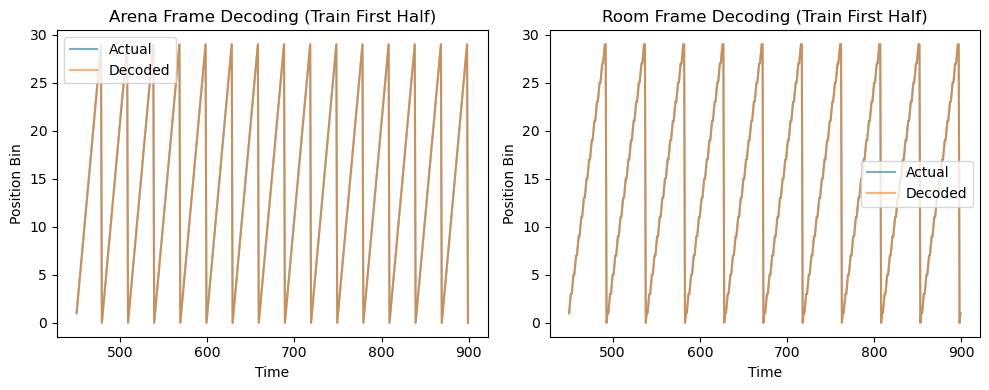

In [12]:
from sklearn.linear_model import LogisticRegression

# Transpose for sklearn: (time, neurons)
X = activations_C.T  # shape: (time, neurons)
y_arena = positions_Arena_C
y_room = positions_Room_C

# Split in half
N = X.shape[0]
half = N // 2

X_train, X_test = X[:half], X[half:]
y_arena_train, y_arena_test = y_arena[:half], y_arena[half:]
y_room_train, y_room_test   = y_room[:half],  y_room[half:]

# Train on first half
clf_arena = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000).fit(X_train, y_arena_train)
clf_room  = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000).fit(X_train, y_room_train)

# Predict on second half
decoded_arena_bins = clf_arena.predict(X_test)
decoded_room_bins  = clf_room.predict(X_test)

# Plot predictions vs actual (second half only)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(half, N), y_arena_test, label='Actual', alpha=0.6)
plt.plot(range(half, N), decoded_arena_bins, label='Decoded', alpha=0.6)
plt.title('Arena Frame Decoding (Train First Half)')
plt.xlabel('Time')
plt.ylabel('Position Bin')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(half, N), y_room_test, label='Actual', alpha=0.6)
plt.plot(range(half, N), decoded_room_bins, label='Decoded', alpha=0.6)
plt.title('Room Frame Decoding (Train First Half)')
plt.xlabel('Time')
plt.ylabel('Position Bin')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# Parameters
n_neurons, n_time = activations_C.shape
position_bins = np.max(positions_Arena_C) + 1  # assuming positions are 0-indexed ints
k_bins = np.linspace(0, 1.4, 50)  # fine-grained bins for spike counts

# Output: Ipos[neuron, position]
Ipos = np.zeros((n_neurons, position_bins))

# Loop over neurons
for i in range(n_neurons):
    spikes = activations_C[i]                # shape: (time,)
    positions = positions_Arena_C            # shape: (time,)

    # Global spike histogram: P(k)
    hist_all, _ = np.histogram(spikes, bins=k_bins, density=True)
    P_k_global = hist_all / np.sum(hist_all) + 1e-12  # small value to avoid log(0)

    # Loop over position bins
    for x in range(position_bins):
        # Get spike values when in position x
        spikes_at_x = spikes[positions == x]
        if len(spikes_at_x) < 5:
            continue  # skip poorly sampled bins

        hist_pos, _ = np.histogram(spikes_at_x, bins=k_bins, density=True)
        P_k_given_x = hist_pos / np.sum(hist_pos) + 1e-12

        # Compute Ipos(x) for neuron i
        ratio = P_k_given_x / P_k_global
        info = P_k_given_x * np.log2(ratio)
        Ipos[i, x] = np.sum(info)

# Ipos is now a [neurons x position] array


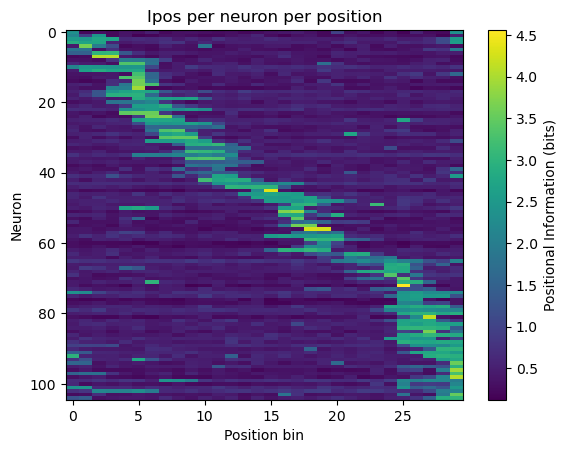

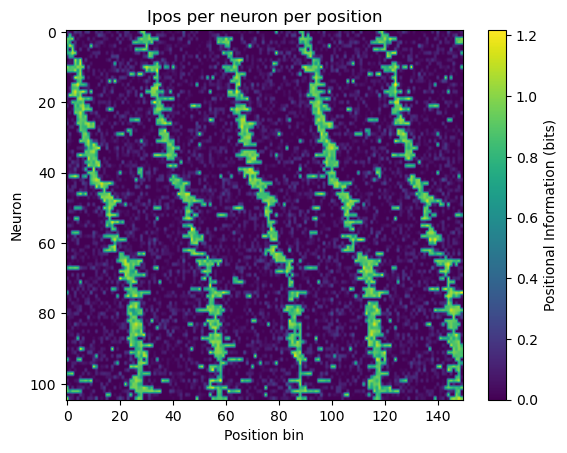

In [14]:
# Plot positional information map for a few neurons
plt.imshow(Ipos[sorted_selected_indices_C_Arena], aspect='auto', cmap='viridis')
plt.colorbar(label='Positional Information (bits)')
plt.xlabel('Position bin')
plt.ylabel('Neuron')
plt.title('Ipos per neuron per position')
plt.show()

# Plot positional information map for a few neurons
plt.imshow(activations_C[sorted_selected_indices_C_Arena,:150], aspect='auto', cmap='viridis')
plt.colorbar(label='Positional Information (bits)')
plt.xlabel('Position bin')
plt.ylabel('Neuron')
plt.title('Ipos per neuron per position')
plt.show()

In [15]:
# Setup
n_neurons, n_time = activations_C.shape
k_bins = np.linspace(0, 1.4, 30)
k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
n_bins = np.max(positions_Arena_C) + 1  # assuming positions are 0-indexed

# Preallocate
Ipos_arena = np.zeros((n_neurons, n_time))
Ipos_room = np.zeros((n_neurons, n_time))
EnIpos_arena  = np.zeros(n_time)
EnIpos_room  = np.zeros(n_time)

# Loop over neurons
for i in range(n_neurons):
    spikes = activations_C[i]  # (time,)

    # Global spike histogram
    Pk_global, _ = np.histogram(spikes, bins=k_bins, density=True)
    Pk_global /= Pk_global.sum() + 1e-12

    # Conditional histograms: P(k | x) for each position bin
    Pk_given_x_arena = np.zeros((n_bins, len(k_bin_centers)))
    Pk_given_x_room = np.zeros((n_bins, len(k_bin_centers)))

    for x in range(n_bins):
        idx_arena = np.where(positions_Arena_C == x)[0]
        idx_room = np.where(positions_Room_C == x)[0]

        if len(idx_arena) > 5:
            h_arena, _ = np.histogram(spikes[idx_arena], bins=k_bins, density=True)
            Pk_given_x_arena[x] = h_arena / (h_arena.sum() + 1e-12)
        if len(idx_room) > 5:
            h_room, _ = np.histogram(spikes[idx_room], bins=k_bins, density=True)
            Pk_given_x_room[x] = h_room / (h_room.sum() + 1e-12)

    # Compute moment-by-moment Ipos using true position at time t
    for t in range(n_time):
        k_t = spikes[t]
        bin_idx = np.argmin(np.abs(k_bin_centers - k_t))  # closest k bin

        x_arena = positions_Arena_C[t]
        x_room = positions_Room_C[t]

        Pk_arena = Pk_given_x_arena[x_arena, bin_idx]
        Pk_room  = Pk_given_x_room[x_room, bin_idx]
        Pk = Pk_global[bin_idx]

        if Pk > 0:
            if Pk_arena > 0:
                Ipos_arena[i, t] = Pk_arena * np.log2(Pk_arena / Pk)
                EnIpos_arena[t] = np.sum(Ipos_arena[:,t])

            if Pk_room > 0:
                Ipos_room[i, t] = Pk_room * np.log2(Pk_room / Pk)
                EnIpos_room[t] = np.sum(Ipos_room[:,t])



In [16]:
# Compute difference
Ipos_diff = Ipos_room - Ipos_arena  # shape: (neurons, time)
EnIpos_diff = EnIpos_room - EnIpos_arena  # shape: (neurons, time)


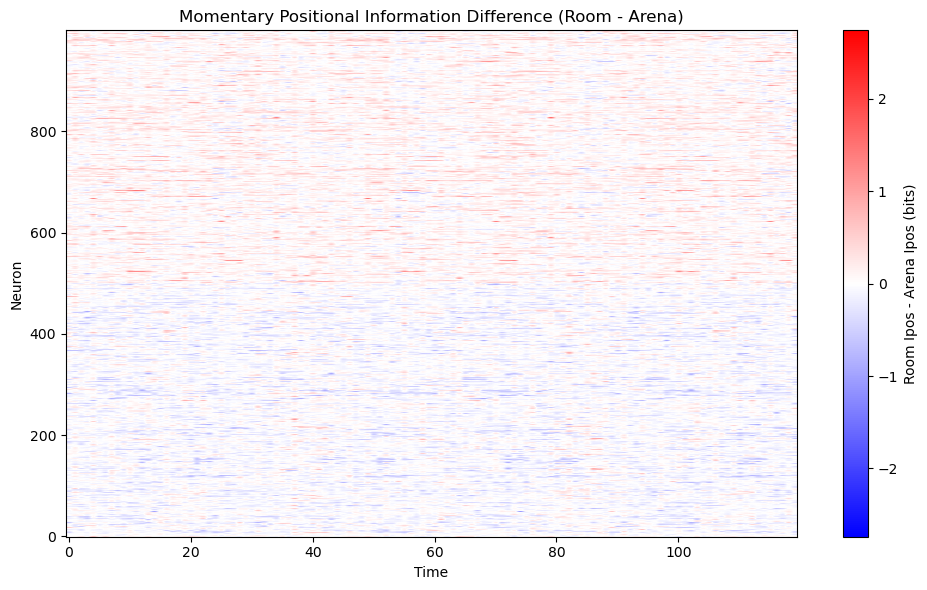

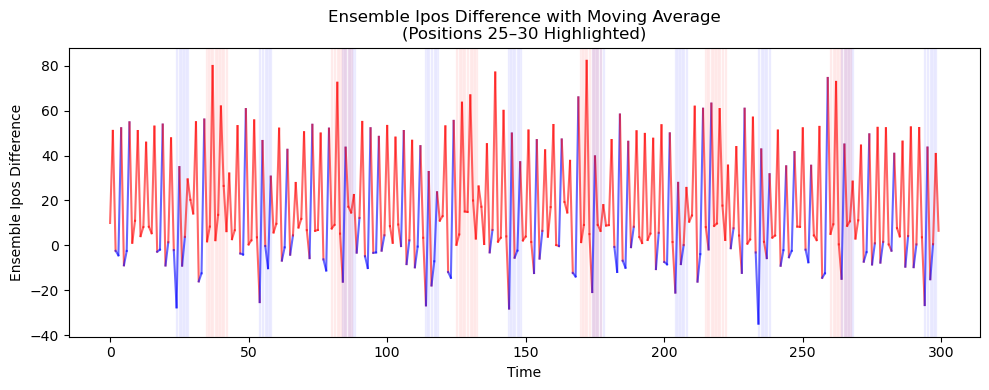

In [17]:
# Plot
plt.figure(figsize=(10, 6))
plt.imshow(Ipos_diff[:,:120], aspect='auto', origin='lower', cmap='bwr', vmin=-np.max(np.abs(Ipos_diff)), vmax=np.max(np.abs(Ipos_diff)))
plt.colorbar(label='Room Ipos - Arena Ipos (bits)')
plt.xlabel('Time')
plt.ylabel('Neuron')
plt.title('Momentary Positional Information Difference (Room - Arena)')
plt.tight_layout()
plt.show()



Duration = 300
window_size = 5  # Adjust this for smoothing strength

# Compute moving average
kernel = np.ones(window_size) / window_size
moving_avg = np.convolve(EnIpos_diff[:Duration], kernel, mode='same')
plt.figure(figsize=(10, 4))

# Plot color-coded EnIpos_diff
for i in range(Duration - 1):
    x = [i, i+1]
    y = [EnIpos_diff[i], EnIpos_diff[i+1]]
    color = 'red' if EnIpos_diff[i] > 0 else 'blue'
    plt.plot(x, y, color=color, alpha=0.6)

# # Overlay moving average
# plt.plot(moving_avg[:Duration], label=f'Moving Avg (window={window_size})', linewidth=2, color='black')

# plt.title("Ensemble Ipos Difference with Color-Coded Segments")
# plt.xlabel("Time")
# plt.ylabel("Ensemble Ipos Difference")
# plt.legend()
# plt.tight_layout()
# plt.show()


# Highlight times when position is between 25 and 30 (inclusive)
room_times = np.where((positions_Room_C[:Duration] >= 25) & (positions_Room_C[:Duration] <= 30))[0]
arena_times = np.where((positions_Arena_C[:Duration] >= 25) & (positions_Arena_C[:Duration] <= 30))[0]

for t in room_times:
    plt.axvspan(t - 0.25, t + 0.25, color='red', alpha=0.05)
for t in arena_times:
    plt.axvspan(t - 0.25, t + 0.25, color='blue', alpha=0.05)

plt.title("Ensemble Ipos Difference with Moving Average\n(Positions 25–30 Highlighted)")
plt.xlabel("Time")
plt.ylabel("Ensemble Ipos Difference")
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


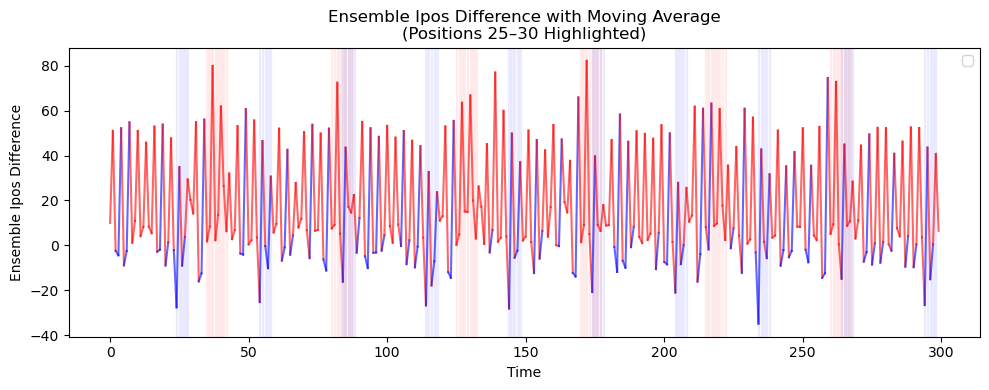

In [18]:
Figure_path = '/mnt/home/jhurtado/ceph/Capacity/SimpleModel/Figures'

Duration = 300
window_size = 5  # Adjust this for smoothing strength

# Compute moving average
kernel = np.ones(window_size) / window_size
moving_avg = np.convolve(EnIpos_diff[:Duration], kernel, mode='same')

fig = plt.figure(figsize=(10, 4))

# Plot color-coded EnIpos_diff
for i in range(Duration - 1):
    x = [i, i + 1]
    y = [EnIpos_diff[i], EnIpos_diff[i + 1]]
    color = 'red' if EnIpos_diff[i] > 0 else 'blue'
    plt.plot(x, y, color=color, alpha=0.6)

# Highlight times when position is between 25 and 30 (inclusive)
room_times = np.where((positions_Room_C[:Duration] >= 25) & (positions_Room_C[:Duration] <= 30))[0]
arena_times = np.where((positions_Arena_C[:Duration] >= 25) & (positions_Arena_C[:Duration] <= 30))[0]

for t in room_times:
    plt.axvspan(t - 0.25, t + 0.25, color='red', alpha=0.05)
for t in arena_times:
    plt.axvspan(t - 0.25, t + 0.25, color='blue', alpha=0.05)

plt.title("Ensemble Ipos Difference with Moving Average\n(Positions 25–30 Highlighted)")
plt.xlabel("Time")
plt.ylabel("Ensemble Ipos Difference")
plt.legend()
plt.tight_layout()

# Save the figure
save_filename = os.path.join(Figure_path, "IposDiff_Ensemble.svg")
fig.savefig(save_filename, format='svg', bbox_inches='tight')
plt.show()


In [19]:
# Concatenate selected neurons
Neurons_Selected_Arena = sorted_selected_indices_C_Arena
Neurons_Selected_Room = sorted_selected_indices_C_Room
Neurons_Selected = np.unique(np.concatenate([Neurons_Selected_Arena, Neurons_Selected_Room]))

# Setup
n_neurons, n_time = activations_C.shape
k_bins = np.linspace(0, 1.4, 30)
k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
n_bins = np.max(positions_Arena_C) + 1  # assuming positions are 0-indexed

# Smooth activations (optional: keep if you smoothed before)
smoothed_activations = np.apply_along_axis(
    lambda x: np.convolve(x, np.ones(5)/5, mode='same'),
    axis=1,
    arr=activations_C
)

# Preallocate only for selected neurons
Ipos_arena = np.zeros((len(Neurons_Selected), n_time))
Ipos_room = np.zeros((len(Neurons_Selected), n_time))
EnIpos_arena = np.zeros(n_time)
EnIpos_room = np.zeros(n_time)

# Loop over selected neurons
for n_idx, i in enumerate(Neurons_Selected):
    spikes = smoothed_activations[i]

    # Global spike histogram
    Pk_global, _ = np.histogram(spikes, bins=k_bins, density=True)
    Pk_global /= Pk_global.sum() + 1e-12

    # Conditional histograms: P(k | x)
    Pk_given_x_arena = np.zeros((n_bins, len(k_bin_centers)))
    Pk_given_x_room  = np.zeros((n_bins, len(k_bin_centers)))

    for x in range(n_bins):
        idx_arena = np.where(positions_Arena_C == x)[0]
        idx_room  = np.where(positions_Room_C == x)[0]

        if len(idx_arena) > 5:
            h_arena, _ = np.histogram(spikes[idx_arena], bins=k_bins, density=True)
            Pk_given_x_arena[x] = h_arena / (h_arena.sum() + 1e-12)
        if len(idx_room) > 5:
            h_room, _ = np.histogram(spikes[idx_room], bins=k_bins, density=True)
            Pk_given_x_room[x] = h_room / (h_room.sum() + 1e-12)

    # Moment-by-moment Ipos
    for t in range(n_time):
        k_t = spikes[t]
        bin_idx = np.argmin(np.abs(k_bin_centers - k_t))

        x_arena = positions_Arena_C[t]
        x_room  = positions_Room_C[t]

        Pk_arena = Pk_given_x_arena[x_arena, bin_idx]
        Pk_room  = Pk_given_x_room[x_room, bin_idx]
        Pk       = Pk_global[bin_idx]

        if Pk > 0:
            if Pk_arena > 0:
                Ipos_arena[n_idx, t] = Pk_arena * np.log2(Pk_arena / Pk)
            if Pk_room > 0:
                Ipos_room[n_idx, t] = Pk_room * np.log2(Pk_room / Pk)

# Ensemble-level Ipos from selected neurons only
EnIpos_arena = np.sum(Ipos_arena, axis=0)
EnIpos_room  = np.sum(Ipos_room, axis=0)
EnIpos_diff  = EnIpos_room - EnIpos_arena
Ipos_diff = Ipos_room - Ipos_arena  # shape: (neurons, time)


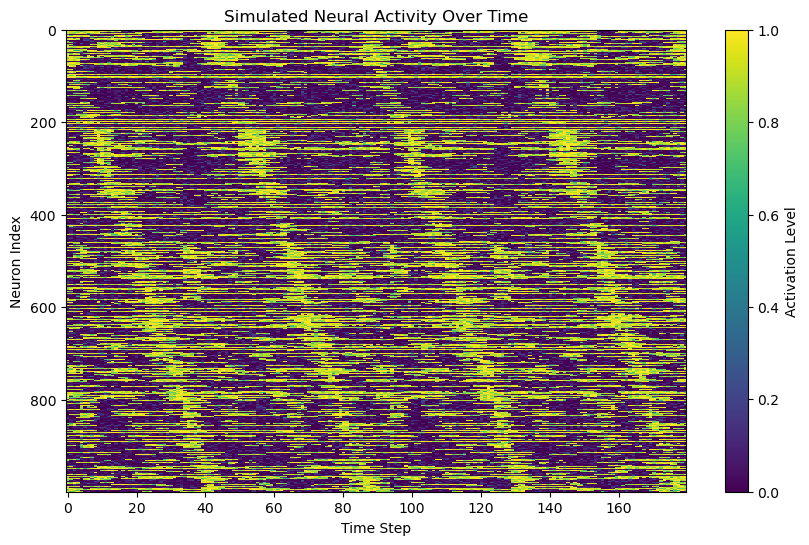

In [20]:

Figure_path = '/mnt/home/jhurtado/ceph/Capacity/SimpleModel/Figures'

Start=360
End=540


# Visualize the activations using imshow()
fig=plt.figure(figsize=(10, 6))
plt.imshow(activations_combined[indices_peak_A,Start:End], aspect='auto', cmap='viridis', interpolation='none',vmin=0,vmax=1)
plt.colorbar(label='Activation Level')
plt.xlabel('Time Step')
plt.ylabel('Neuron Index')
plt.title('Simulated Neural Activity Over Time')
# save_filename = os.path.join(Figure_path, "Rates_DivPre.svg")
# fig.savefig(save_filename, format='svg', bbox_inches='tight')

plt.show()


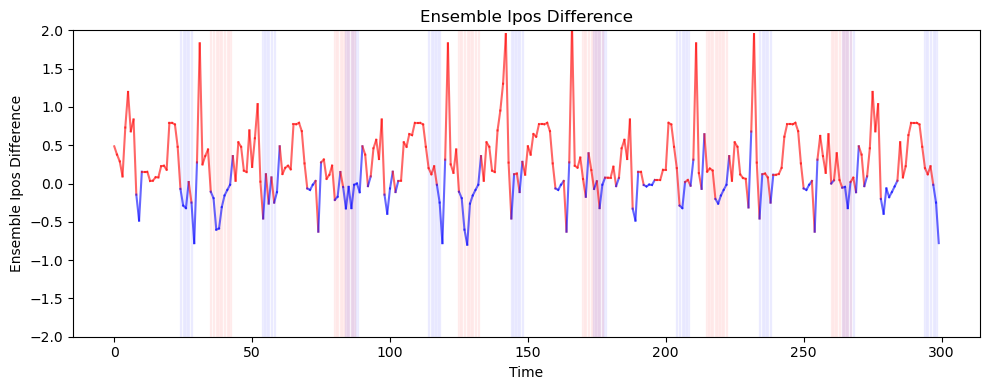

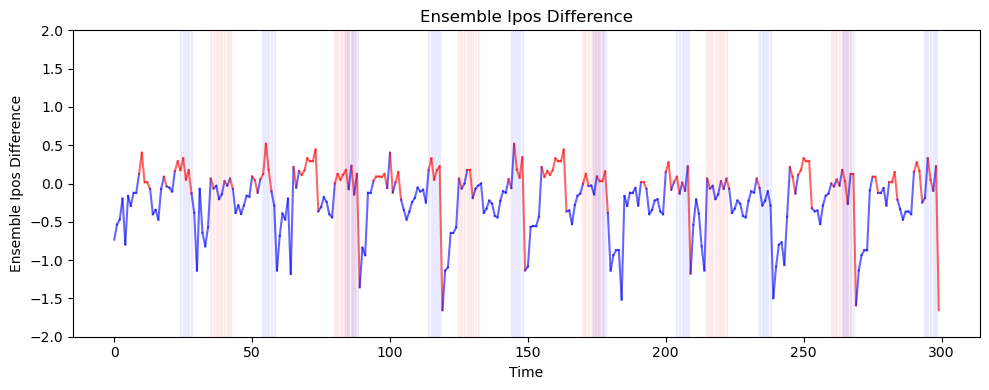

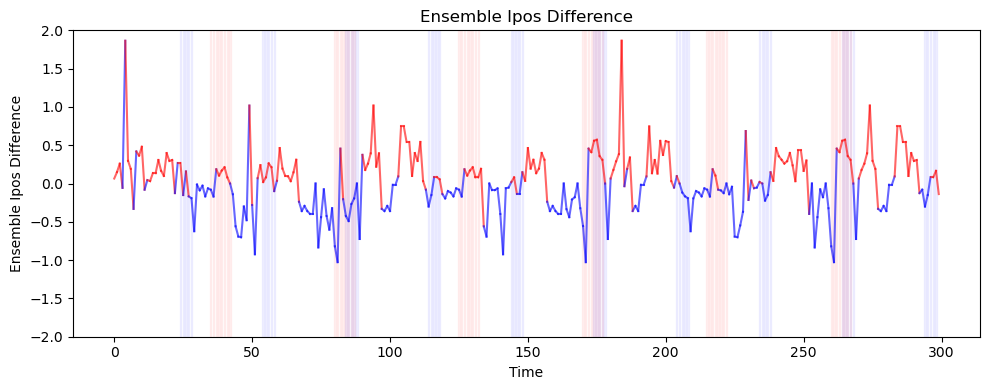

In [21]:

Figure_path = '/mnt/home/jhurtado/ceph/Capacity/SimpleModel/Figures'

Neu = 0
Ipos_diff = Ipos_room - Ipos_arena  # shape: (neurons, time)
Duration = 300
window_size = 5

kernel = np.ones(window_size) / window_size
moving_avg = np.convolve(Ipos_diff[Neu, :Duration], kernel, mode='same')

fig = plt.figure(figsize=(10, 4))
for i in range(Duration - 1):
    x = [i, i + 1]
    y = [Ipos_diff[Neu, i], Ipos_diff[Neu, i + 1]]
    color = 'red' if Ipos_diff[Neu, i] > 0 else 'blue'
    plt.plot(x, y, color=color, alpha=0.6)

room_times = np.where((positions_Room_C[:Duration] >= 25) & (positions_Room_C[:Duration] <= 30))[0]
arena_times = np.where((positions_Arena_C[:Duration] >= 25) & (positions_Arena_C[:Duration] <= 30))[0]

for t in room_times:
    plt.axvspan(t - 0.25, t + 0.25, color='red', alpha=0.05)
for t in arena_times:
    plt.axvspan(t - 0.25, t + 0.25, color='blue', alpha=0.05)

plt.title("Ensemble Ipos Difference")
plt.xlabel("Time")
plt.ylabel("Ensemble Ipos Difference")
plt.ylim(-2, 2)
plt.tight_layout()
# save_filename = os.path.join(Figure_path, "IposDiff_Neuron0.svg")
# fig.savefig(save_filename, format='svg', bbox_inches='tight')
plt.show()

# --------------------------------------

Neu = 6
moving_avg = np.convolve(Ipos_diff[Neu, :Duration], kernel, mode='same')

fig = plt.figure(figsize=(10, 4))
for i in range(Duration - 1):
    x = [i, i + 1]
    y = [Ipos_diff[Neu, i], Ipos_diff[Neu, i + 1]]
    color = 'red' if Ipos_diff[Neu, i] > 0 else 'blue'
    plt.plot(x, y, color=color, alpha=0.6)

room_times = np.where((positions_Room_C[:Duration] >= 25) & (positions_Room_C[:Duration] <= 30))[0]
arena_times = np.where((positions_Arena_C[:Duration] >= 25) & (positions_Arena_C[:Duration] <= 30))[0]

for t in room_times:
    plt.axvspan(t - 0.25, t + 0.25, color='red', alpha=0.05)
for t in arena_times:
    plt.axvspan(t - 0.25, t + 0.25, color='blue', alpha=0.05)

plt.title("Ensemble Ipos Difference")
plt.xlabel("Time")
plt.ylabel("Ensemble Ipos Difference")
plt.ylim(-2, 2)
plt.tight_layout()
# save_filename = os.path.join(Figure_path, "IposDiff_Neuron6.svg")
# fig.savefig(save_filename, format='svg', bbox_inches='tight')
plt.show()

# --------------------------------------

Neu = 4
moving_avg = np.convolve(Ipos_diff[Neu, :Duration], kernel, mode='same')

fig = plt.figure(figsize=(10, 4))
for i in range(Duration - 1):
    x = [i, i + 1]
    y = [Ipos_diff[Neu, i], Ipos_diff[Neu, i + 1]]
    color = 'red' if Ipos_diff[Neu, i] > 0 else 'blue'
    plt.plot(x, y, color=color, alpha=0.6)

room_times = np.where((positions_Room_C[:Duration] >= 25) & (positions_Room_C[:Duration] <= 30))[0]
arena_times = np.where((positions_Arena_C[:Duration] >= 25) & (positions_Arena_C[:Duration] <= 30))[0]

for t in room_times:
    plt.axvspan(t - 0.25, t + 0.25, color='red', alpha=0.05)
for t in arena_times:
    plt.axvspan(t - 0.25, t + 0.25, color='blue', alpha=0.05)

plt.title("Ensemble Ipos Difference")
plt.xlabel("Time")
plt.ylabel("Ensemble Ipos Difference")
plt.ylim(-2, 2)
plt.tight_layout()
# save_filename = os.path.join(Figure_path, "IposDiff_Neuron4.svg")
# fig.savefig(save_filename, format='svg', bbox_inches='tight')
plt.show()


[[266], [807], [214], [891]]


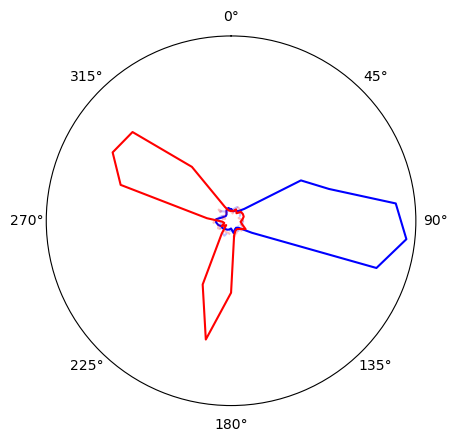

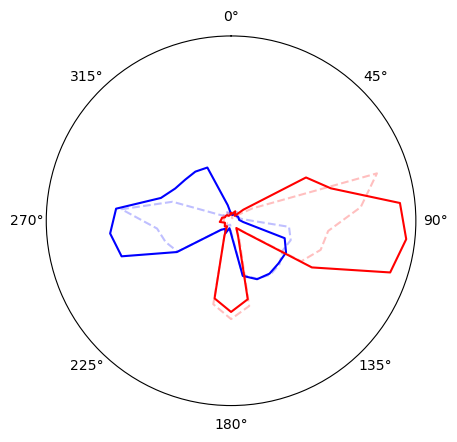

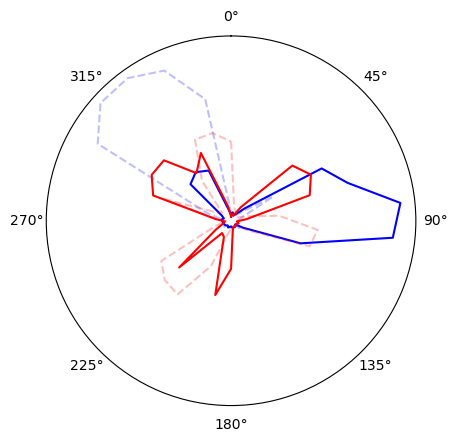

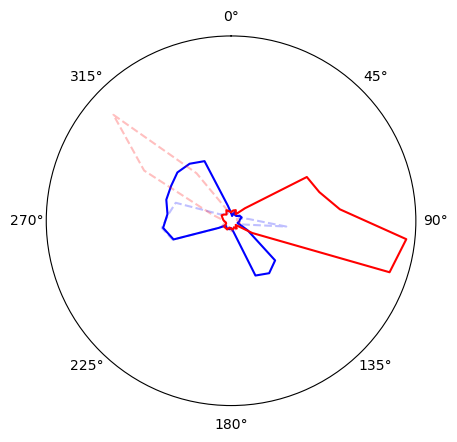

In [22]:
from scipy.ndimage import gaussian_filter1d

Figure_path = '/mnt/home/jhurtado/ceph/Capacity/SimpleModel/Figures'



# === SETTINGS ===
sigma = 0.5
n_bins = tuning_curves_A_Arena.shape[1]
angles = np.linspace(0, 2 * np.pi, n_bins, endpoint=False)
angles = np.append(angles, angles[0])

def wrap_and_smooth(curve, sigma=0.5):
    smoothed = gaussian_filter1d(curve, sigma)
    return np.append(smoothed, smoothed[0])

def add_radial_lines(ax, r_max=1):
    r = np.linspace(0, r_max, 100)
    ax.plot(np.full_like(r, angles[7]), r, color='black', linestyle='-', linewidth=1.5, alpha=1.0)
    ax.plot(np.full_like(r, angles[27]), r, color='black', linestyle='--', linewidth=1.5, alpha=0.25)

# For Place-preferring cells
valid_i = [
    i for i in range(len(ArenaFrame_Place))
    if all(set(np.atleast_1d(ArenaFrame_Place[i])).isdisjoint(set(np.atleast_1d(rp)))
           for rp in RoomFrame_Place)
]

valid_j = [
    j for j in range(len(RoomFrame_Place))
    if all(set(np.atleast_1d(RoomFrame_Place[j])).isdisjoint(set(np.atleast_1d(ap)))
           for ap in ArenaFrame_Place)
]

# For Goal-preferring cells
valid_k = [
    k for k in range(len(ArenaFrame_Object))
    if all(set(np.atleast_1d(ArenaFrame_Object[k])).isdisjoint(set(np.atleast_1d(ro)))
           for ro in RoomFrame_Object)
]

valid_l = [
    l for l in range(len(RoomFrame_Object))
    if all(set(np.atleast_1d(RoomFrame_Object[l])).isdisjoint(set(np.atleast_1d(ao)))
           for ao in ArenaFrame_Object)
]


i = valid_i[40]
j = valid_j[22]
k = valid_k[3]
l = valid_l[1]

cells = {
    'Arena_Preferring_Place': ArenaFrame_Place[i],
    'Room_Preferring_Place': RoomFrame_Place[j],
    'Arena_Goal': ArenaFrame_Object[k],
    'Room_Goal': RoomFrame_Object[l]
}




for title, neuron in cells.items():
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    # Arena frame (blue)
    A_arena = wrap_and_smooth(tuning_curves_A_Arena[neuron, :], sigma)
    C_arena = wrap_and_smooth(tuning_curves_C_Arena[neuron, :], sigma)
    ax.plot(angles, A_arena, color='blue', label='Arena A')
    ax.plot(angles, C_arena, color='blue', linestyle='--', alpha=0.25, label='Arena C')

    # Room frame (red)
    A_room = wrap_and_smooth(tuning_curves_A_Room[neuron, :], sigma)
    C_room = wrap_and_smooth(tuning_curves_C_Room[neuron, :], sigma)
    ax.plot(angles, A_room, color='red', label='Room A')
    ax.plot(angles, C_room, color='red', linestyle='--', alpha=0.25, label='Room C')

    # Formatting
    r_max = max(A_arena.max(), A_room.max())
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_yticklabels([])
    ax.grid(False)

    # # Save
    # filename = os.path.join(Figure_path, f"TuningCurve_{title}.svg")
    # fig.savefig(filename, format='svg', bbox_inches='tight')
    # plt.close(fig)  # Close the figure to avoid display

def get_sorted_positions(raw_indices, sorted_indices):
    raw_indices = np.atleast_1d(raw_indices)
    return [np.where(sorted_indices == idx)[0][0] for idx in raw_indices if idx in sorted_indices]

print([
    get_sorted_positions(ArenaFrame_Place[i], sorted_indices_A_Arena),
    get_sorted_positions(RoomFrame_Place[j], sorted_indices_A_Arena),
    get_sorted_positions(ArenaFrame_Object[k], sorted_indices_A_Arena),
    get_sorted_positions(RoomFrame_Object[l], sorted_indices_A_Arena)
])

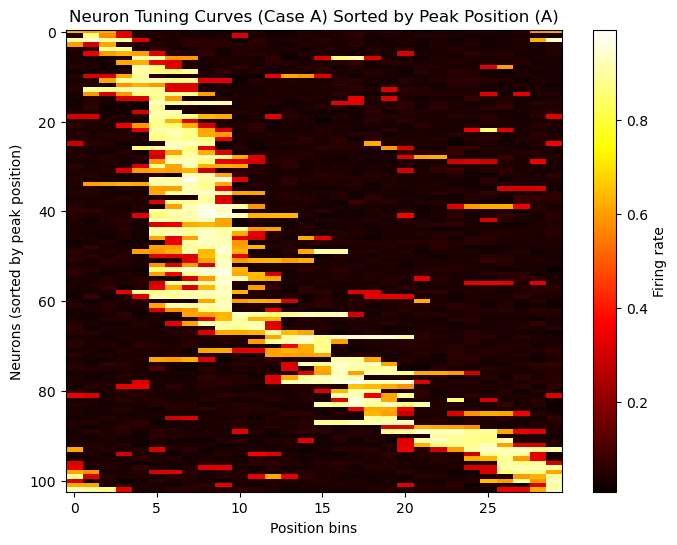

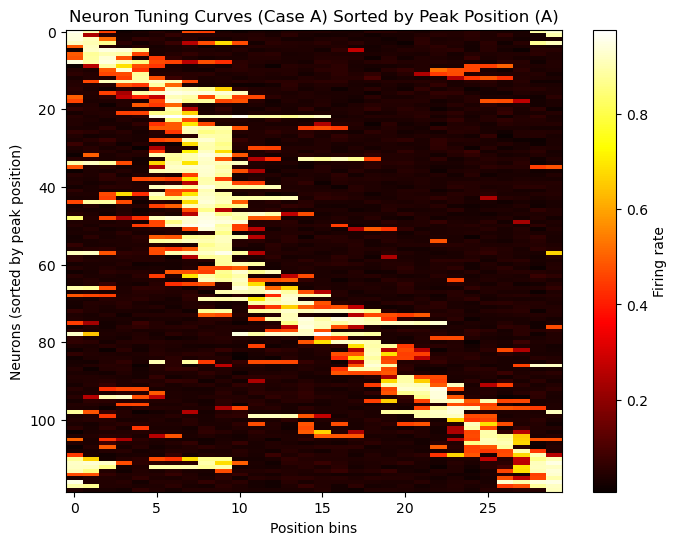

In [23]:
# Save


# Plot tuning curves for Case A sorted by A
fig=plt.figure(figsize=(8, 6))
plt.imshow(tuning_curves_A_Arena[ArenaFrame_Place, :], aspect='auto', cmap='hot', interpolation='nearest')
plt.xlabel("Position bins")
plt.ylabel("Neurons (sorted by peak position)")
plt.colorbar(label="Firing rate")
plt.title("Neuron Tuning Curves (Case A) Sorted by Peak Position (A)")
# filename = os.path.join(Figure_path, f"Place_ArenaRates.svg")
# fig.savefig(filename, format='svg', bbox_inches='tight')
plt.show()

# Plot tuning curves for Case A sorted by A
fig=plt.figure(figsize=(8, 6))
plt.imshow(tuning_curves_A_Room[RoomFrame_Place, :], aspect='auto', cmap='hot', interpolation='nearest')
plt.xlabel("Position bins")
plt.ylabel("Neurons (sorted by peak position)")
plt.colorbar(label="Firing rate")
plt.title("Neuron Tuning Curves (Case A) Sorted by Peak Position (A)")
# filename = os.path.join(Figure_path, f"Place_RoomRates.svg")
# fig.savefig(filename, format='svg', bbox_inches='tight')
plt.show()